# AI-Based Spam Detection: ShieldSecure Protecting Clients
*  ShieldSecure faces a challenge of client's inboxes flooded with spam. These spams bypassing traditional filters increases phishing and malware risks. To tackle this, we developed an AI-based spam detector using the "cmm541data" dataset. We tested several algorithms, including Naive Bayes and Random Forest with a focus on less false negatives(missing spam).
*  After testing, the top-performing model was Random Forest. It produced high accuracy and fewer false negatives. It also handles the data imbalance effectively. For now, we can conclude that Random Forest is reliable with a test accuracy of 99.83% and an AUC-ROC close to 1.
*  Considering vulnerabilities, attackers may attempt to bypass detection using by modifying text. Hence, we must regularly update the model to stay ahead of evolving spam tactics. Also, we addressed privacy concerns by anonymizing email data (removing email address and replacing with placeholder).
*   Random Forest is ShieldSecure's best model for spam detection. It delivers high accuracy, reduces false positives, and handles data imbalance well. It's also adaptable to emerging spam techniques.

## Data Cleaning and Exploratory

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import os
import chardet
import re
from tqdm import tqdm  # Import tqdm for the progress bar
import pickle #save jobs
import joblib #save models
from collections import Counter
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import sys
import time
import warnings
warnings.filterwarnings("ignore")
import textwrap
from getpass import getpass
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Save path to the zip file
zip_file_path = 'cmm541data_1st diet.zip'

# Specifying the directory where the files will be extracted to
extract_dir = 'extracted_files'

# Creating directory to save zip contents
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents into the directory created
    zip_ref.extractall(extract_dir)

print(f"Files have been successfully extracted to {extract_dir}")

Files have been successfully extracted to extracted_files


In [4]:
# Define the directory where the emails were extracted
emails_dir = 'extracted_files/cmm541data/emails'
email_files = os.listdir(emails_dir)  # List all email files

# Check the first 5 email files
print(email_files[:5])

['cmm541email.72266', 'cmm541email.36270', 'cmm541email.54010', 'cmm541email.64799', 'cmm541email.27684']


In [5]:
# Load labels path to view a sample of labels
labels_path = 'extracted_files/cmm541data/labels'

# Initialize an empty dictionary to hold the labels
email_labels = {}

# Read the labels file
with open(labels_path, 'r') as file:
    labels = file.readlines()

# For each row, extract the label and email file path
for line in labels:
    parts = line.strip().split()
    if len(parts) == 2:
        label, email_file = parts
        email_labels[email_file] = label

# Create a DataFrame from the above dictionary
elabel = pd.DataFrame(list(email_labels.items()), columns=['email_file', 'label'])

# Display the label DataFrame
elabel

,email_file,label
0,../emails/cmm541email.1,spam
1,../emails/cmm541email.2,ham
2,../emails/cmm541email.3,spam
3,../emails/cmm541email.4,spam
4,../emails/cmm541email.5,spam
...,...,...
75410,../emails/cmm541email.75411,spam
75411,../emails/cmm541email.75412,spam
75412,../emails/cmm541email.75413,spam
75413,../emails/cmm541email.75414,spam


In [6]:
#Distribution of Email using labels
label_counts = elabel['label'].value_counts()
label_counts

,count
label,
spam,50197
ham,25218


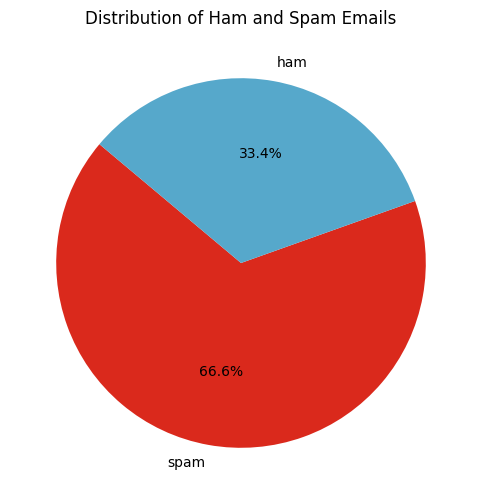

In [7]:
# Plot the distribution of ham and spam using pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#DA291CFF','#56A8CBFF'])
plt.title("Distribution of Ham and Spam Emails")
plt.show()

The dataset contains 75,415 emails, labeled as ham or spam. The plot above clearly shows a data imbalance between the two classes.

In [8]:
# The directory where the email files are located
emails_dir = 'extracted_files/cmm541data/emails'

# The target directories for spam and ham
spam_dir = 'spam'
ham_dir = 'ham'

# Create directories for each label
os.makedirs(spam_dir, exist_ok=True)
os.makedirs(ham_dir, exist_ok=True)

# The email labels
spam_count = 0
ham_count = 0

# Loop through the created label dataframe to split the emails
for index, row in tqdm(elabel.iterrows(), total=elabel.shape[0], desc="Copying Emails"):
    email_file = row['email_file']
    label = row['label']

    # source file path
    source_file_path = os.path.join(emails_dir, email_file)

    # check if source file exists and copy to the right folder using the label
    if os.path.exists(source_file_path):
        if label.lower() == 'spam':
            shutil.copy(source_file_path, spam_dir)
            spam_count += 1
        else:
            shutil.copy(source_file_path, ham_dir)
            ham_count += 1

# Print the total files copied
print(" ")
print(f"Total spam files copied: {spam_count}")
print(f"Total ham files copied: {ham_count}")


Copying Emails: 100%|██████████| 75415/75415 [01:18<00:00, 964.84it/s] 

 
Total spam files copied: 50197
Total ham files copied: 25218


In [9]:
# Define the paths to ham and spam folders
ham_folder = 'ham'
spam_folder = 'spam'

# Initialize an empty list to store the email content and labels
data = []

# Read ham files
ham_files = os.listdir(ham_folder)
for filename in tqdm(ham_files, desc='Reading ham files'):
    file_path = os.path.join(ham_folder, filename)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
        data.append((content, 'ham'))

# Read spam files
spam_files = os.listdir(spam_folder)
for filename in tqdm(spam_files, desc='Reading spam files'):
    file_path = os.path.join(spam_folder, filename)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
        data.append((content, 'spam'))

# Create a DataFrame from the data list
edf = pd.DataFrame(data, columns=['text', 'label'])

# Show the first few rows of the DataFrame
print(" ")
print(edf.head())

Reading spam files: 100%|██████████| 50197/50197 [00:02<00:00, 20591.36it/s]

 
                                                text label
0  From r-help-bounces@stat.math.ethz.ch  Mon Apr...   ham
1  From a266287a3e5e358e00689057430990e87daf89afb...   ham
2  From speakup-bounces@braille.uwo.ca  Tue Jun  ...   ham
3  From samba-technical-bounces+ktwarwic=speedy.u...   ham
4  From samba-cvs-bounces+ktwarwic=speedy.uwaterl...   ham


In [10]:
# Add a text length column
edf['text_length'] = edf['text'].apply(len)

# Find average text length for spam and ham
spam_len = edf[edf['label'] == 'spam']['text_length'].mean()
ham_len = edf[edf['label'] == 'ham']['text_length'].mean()

# Display average lengths
print(f"Average text length for Spam emails: {spam_len:.2f} characters")
print(f"Average text length for Ham emails: {ham_len:.2f} characters")

Average text length for Spam emails: 7363.99 characters
Average text length for Ham emails: 8049.82 characters


In [11]:
# Check to ensure no data lost
edf.shape

(75415, 3)

In [12]:
# Check for duplicates
edf.duplicated().any()

False

In [13]:
# print dataframe information
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75415 entries, 0 to 75414
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         75415 non-null  object
 1   label        75415 non-null  object
 2   text_length  75415 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [14]:
# Display a sample of a spam email to help in data cleaning and feature extraction
print("Sample Spam Email:\n")
print(edf[edf['label'] == 'spam']['text'].iloc[0])

Sample Spam Email:

From juliel@gmjf.org  Mon Jul  2 19:58:06 2007
Return-Path: <juliel@gmjf.org>
Received: from -1209016400 ([217.20.82.122])
	by flax9.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l62NvkLG020936
	for <ktwarwics@speedy.uwaterloo.ca>; Mon, 2 Jul 2007 19:58:04 -0400
Received: from gmjf.org (-1210423736 [-1213609232])
	by greenmarketnaturalfoods.com (Qmailv1) with ESMTP id 0794811D18
	for <ktwarwics@speedy.uwaterloo.ca>; Mon, 02 Jul 2007 23:58:01 +0000
Date: Mon, 02 Jul 2007 23:58:01 +0000
From: US NMA <juliel@gmjf.org>
X-Mailer: The Bat! (v2.00.0) Personal
X-Priority: 3
Message-ID: <6383000928.20070702235801@gmjf.org>
To: Ktwarwics <ktwarwics@flax9.uwaterloo.ca>
Subject: The United States National Medical Association
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="----------2E08F6B82E42726"
X-Kaspersky-Antivirus: passed

This is a multi-part message in MIME format.

------------2E08F6B82E42726
Content-Type: text/plain
Content-Transfer-Encoding: 7bit

The U

In [15]:
# Display a sample of a ham email to help in data cleaning and feature extraction
print("Sample Ham Email:\n")
print(edf[edf['label'] == 'ham']['text'].iloc[0])

Sample Ham Email:

From r-help-bounces@stat.math.ethz.ch  Mon Apr 16 18:30:22 2007
Return-Path: <r-help-bounces@stat.math.ethz.ch>
Received: from hypatia.math.ethz.ch (hypatia.math.ethz.ch [129.132.145.15])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with ESMTP id l3GMUG0I019825
	for <ktwarwic@speedy.uwaterloo.ca>; Mon, 16 Apr 2007 18:30:17 -0400
Received: from hypatia.math.ethz.ch (hypatia [129.132.145.15])
	by hypatia.math.ethz.ch (8.13.6/8.13.6) with ESMTP id l3GMScho026028;
	Tue, 17 Apr 2007 00:28:50 +0200
X-Spam-Checker-Version: SpamAssassin 3.1.8 (2007-02-13) on hypatia.math.ethz.ch
X-Spam-Level: 
X-Spam-Status: No, score=0.9 required=5.0 tests=AWL,
	BAYES_95 autolearn=no version=3.1.8
Received: from gator.dt.uh.edu (gator.dt.uh.edu [129.7.174.35])
	by hypatia.math.ethz.ch (8.13.6/8.13.6) with ESMTP id l3GMSSQd025970
	(version=TLSv1/SSLv3 cipher=DHE-RSA-AES256-SHA bits=256 verify=NO)
	for <r-help@hypatia.math.ethz.ch>; Tue, 17 Apr 2007 00:28:29 +0200
Received: from gator.dt.uh.edu (l

## Data preprocessing

*  Remove HTML Tags & Links - Clean HTML tags and links which add noise.

*  Remove headers - Headers and metadata like Subject, To, From, Content-Type, and Date which are common in emails are removed.

*  Normalization - Replace dates, currency, emails, and symbols with placeholders to reduce variation and improve pattern recognition.

*  Stopword removal and tokenization - Remove common words like “the” and split the text into individual words for model to learn in context.

* Lemmatization - Reduce words to their root form, minimizing the vocabulary. Words like ‘buying’ become ‘buy’, reducin


In [16]:
# Stripping HTML and replacing links
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    for a in soup.find_all('a', href=True):
        a.replace_with(f'embeddedlink {a.get_text()}')
    text = soup.get_text()
    return text


# List of keywords to remove lines starting with these patterns
keywords = [
    'From', 'To', 'Subject', 'Date', 'Received', 'Message-ID', 'Return-Path',
    'X-Mailer', 'List-', 'Old-Return-Path', 'X-Spam-Checker-Version','X-Virus-Scanned',
    'X-Spam-Level', 'X-Spam-Status', 'X-Original-To', 'User-Agent','X-MIMETrack','Sent',
    'MIME-Version', 'Content-Type', 'Content-Transfer-Encoding','Thread-Topic','charset','tests',
    'X-RC-Spam', 'X-RC-Virus', 'Resent-Message-ID', 'Resent-From','Reply-To','Content-class',
    'Delivered-To','X-BeenThere','Sender','New Revision','Author','Errors-To','X-Mailman-Version',
    'X-Mailing-List', 'X-Loop', 'List-ID', 'List-Post', 'List-Help','port','Thread-Index','In-Reply-To',
    'List-Subscribe', 'List-Unsubscribe', 'Precedence', 'Resent-Sender','Mailing-List','References',
    'Resent-Date', 'Status', 'Content-Length', 'Lines', 'Message-Id','by','for','id','Cc'
]

# Compile regex pattern with keywords and optional spacing
pattern = r'^\s*(?:' + '|'.join([f'{kw}(?:\\s*:)?' for kw in keywords]) + r'|' \
          r'DKIM_POLICY_SIGNSOME|X-|plot\.zoo).*'

# For each line, check and remove headers
def remove_header(text):

    text = remove_html(text)
    text = re.sub(r'[\[\]<>()]', '', text)
    text_lines = text.splitlines()
    cleaned_lines = [line for line in text_lines if not re.match(pattern, line, re.IGNORECASE)]
    cleaned_text = "\n".join(cleaned_lines)

     #handle dates
    cleaned_text = re.sub(
    r'\s*(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun),? +\w{3} +\d{1,2} +\d{2}:\d{2}:\d{2} +\d{4} ?(?:\([A-Z]+\))? *\n*|'
    r'(?<!\d)\d{1,2} +\w{3} +\d{4} +\d{2}:\d{2}:\d{2} +[-+]\d{4} ?(?:\([A-Z]+\))? *\n*|'
    r'(?<!\d)\d{1,2}\.\d{1,2}\.\d{4} +\d{2}:\d{2}:\d{2} *\n*',
    '',  cleaned_text, flags=re.IGNORECASE
)

    cleaned_text = re.sub(r'mailto:', '', cleaned_text)

    # Replace `?subject=subscribe` with `emailsubscribe`
    cleaned_text = re.sub(r'\S+@\S+\?subject=subscribe', 'emailsubscribe', cleaned_text, flags=re.IGNORECASE)

    # Replace `?subject=unsubscribe` with `emailunsubscribe`
    cleaned_text = re.sub(r'\S+@\S+\?subject=unsubscribe', 'emailunsubscribe', cleaned_text, flags=re.IGNORECASE)

    # Replace any IP address with 'ipaddr'
    cleaned_text = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', 'ipaddr', cleaned_text)

    return cleaned_text


#this shows the progress bar
tqdm.pandas()

# apply to the email_content column
edf['text_noheaders'] = edf['text'].progress_apply(remove_header)

100%|██████████| 75415/75415 [10:17<00:00, 122.18it/s]


In [17]:
print(edf['text_noheaders'][10])

	autolearn=ham version=3.1.7
Content-Disposition: inline
	branches/SAMBA_3_0/source/nsswitch: .
	
	

On Thu, May 31, 2007 at 11:58:57PM +0000, obnox@samba.org wrote:
 
 WebSVN: http://websvn.samba.org/cgi-bin/viewcvs.cgi?view=rev&root=samba&rev=23284
 
 Log:
 Oh what a nasty typo! This gave me some headache,
 with talloc randomly failing.
 
 Hey, shouldn't TALLOC_ARRAY _not_ return NULL when
 requested to allocate an array with zero entries? :-

Yes it should at the moment. It should be calling
_talloc_array_zeronull under the covers in lib/util.c
which explicitly does this.

Was this not happening for you ? I'd like you to
debug that as I can't see a codepath for this not

Jeremy.



In [18]:
 # Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_email(text):

    # Lowercasing
    text = text.lower()

    # Normalize whitespace to handle double spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove dates in various formats
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun),? +\w{3} +\d{1,2} +\d{2}:\d{2}:\d{2} +\d{4}\b|'
                  r'(?<!\d)\d{1,2} +\w{3} +\d{4} +\d{2}:\d{2}:\d{2} [-+]\d{4}\b', '', text)

   # Stripping HTML and replacing links
    soup = BeautifulSoup(text, 'html.parser')
    for a in soup.find_all('a', href=True):
        # Replace anchor tags with "embeddedlink" and the text of the anchor
        a.replace_with(f'embeddedlink {a.get_text()}')
    text = soup.get_text()

    # Find and replace URLs
    text = re.sub(r'http[s]?://\S+', 'url', text)

    # Find and replace email addresses
    text = re.sub(r'\S+@\S+', 'emailaddress', text)

   # Replace occurrences of currency followed by a number ($100) with "cash"
    text = re.sub(r'[$€¥£]\d+', 'cash', text)

    # find and replace numbers
    text = re.sub(r'\b\d+\b', 'number', text)

    # find and replace currency symbols
    text = re.sub(r'[$€¥£]', 'currency', text)

    # replace non-ASCII characters (emojis) with emoji
    text = re.sub(r'[^\x00-\x7F]+', 'emoji', text)

    # Remove non-words and trim whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

   # Make multiple "number" into a single "number"
    text = re.sub(r'(number\s*)+', 'number ', text)
    text = re.sub(r'number\s*number', 'number', text)

    # Tokenization, break words into individual
    tokens = nltk.word_tokenize(text)

    # Handle negations
    tokens = [re.sub(r'\b(not|no|never)\s+(\w+)', r'\2_\1', token) for token in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Word Lemmatization, to its base (swimming to swim)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [19]:
# Show progress
tqdm.pandas()

# Apply the preprocess_email function with a progress bar
edf['processed_text'] = edf['text_noheaders'].progress_apply(preprocess_email)

100%|██████████| 75415/75415 [11:15<00:00, 111.59it/s]


In [20]:
# drop the text_noheaders column
edf.drop(columns=['text_noheaders'], errors='ignore', inplace=True)

In [21]:
#show dataframe
edf

,text,label,text_length,processed_text
0,From r-help-bounces@stat.math.ethz.ch Mon Apr...,ham,2640,tue bayes95 autolearnno versionnumber versiont...
1,From a266287a3e5e358e00689057430990e87daf89afb...,ham,11844,bbc email news html number embeddedlink bbc da...
2,From speakup-bounces@braille.uwo.ca Tue Jun ...,ham,4064,contentdisposition inline begin pgp signed mes...
3,From samba-technical-bounces+ktwarwic=speedy.u...,ham,4508,autolearnno versionnumber tue number jun numbe...
4,From samba-cvs-bounces+ktwarwic=speedy.uwaterl...,ham,17285,norelays autolearnno versionnumber websvn url ...
...,...,...,...,...
75410,From mhln-admin@mailman.eppg.com Wed May 16 0...,spam,3136,replytypeoriginal ride wave hxpn exploding wat...
75411,From lexexperienceprinciplevub@experienceprinc...,spam,5591,fri fri boundary9ef674444b829ef 9ef674444b829e...
75412,From distortiongui@crccom.com Tue May 8 13:5...,spam,3331,feel right home time denver nugget big road tr...
75413,From nobody@server.fastbox.info Fri Apr 13 15...,spam,6987,envelopefrom mouvement desjardins chere membre...


In [40]:
# Save the edf dataframe to a pickle file
with open('edf.pkl', 'wb') as f:
    pickle.dump(edf, f)

Generating Word Clouds:   0%|          | 0/2 [00:00<?, ?it/s]

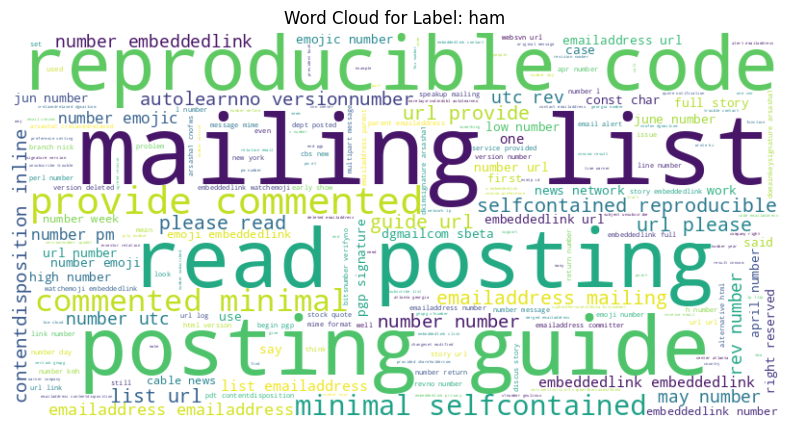

Generating Word Clouds:  50%|█████     | 1/2 [00:49<00:49, 49.01s/it]

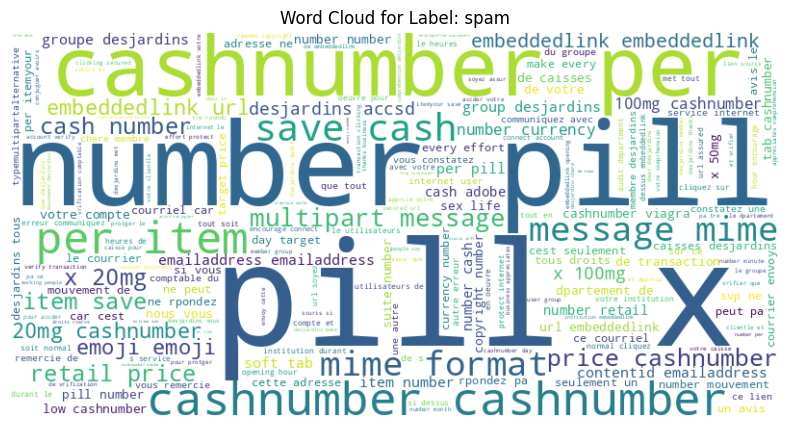

Generating Word Clouds: 100%|██████████| 2/2 [02:03<00:00, 61.66s/it]


In [41]:
# For each label, spam and ham, generate a word cloud to visualize common words
for label in tqdm(edf['label'].unique(), desc='Generating Word Clouds'):
    filtered_df = edf[edf['label'] == label]
    texts = ' '.join(filtered_df['processed_text'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()


## Feature Engineering

To improve model classification, both content patterns and email metadata was used by performing;

1. Text Vectorization:

Used Count and TF-IDF to capture both word frequency and importance.

2. Feature Combination:

Then the extracted email metadata and vectorized content was combined to train the model.

In [ ]:
# Feature extraction
      #extract subject
extract_subject = lambda content: (
    re.search(r'subject:\s*(.*)', content, re.IGNORECASE).group(1)
    if re.search(r'subject:\s*(.*)', content, re.IGNORECASE) else 'No Subject')
      # extract sender
extract_sender = lambda content: (
    re.search(r'from\s*:\s*(\S+@\S+)', content.lower()).group(1) if re.search(r'from\s*:\s*(\S+@\S+)', content.lower())
    else re.search(r'from\s+(\S+@\S+)', content.lower()).group(1) if re.search(r'from\s+(\S+@\S+)', content.lower())
    else 'Unknown Sender')
      # check if email is tagged as high priority
is_high_priority = lambda content: int(bool(re.search(r'X-Priority:\s*1', content, re.IGNORECASE)))
      # extract email sent time
extract_sent_datetime = lambda content: re.search(r'Date:\s*(.*)', content).group(1).strip() if re.search(r'Date:\s*(.*)', content) else None
      # check if email has links,both in html as embedded or plain
has_links = lambda content: int(bool(re.search(r'http[s]?://', content)) or bool(re.search(r'<a\s+href=', content, re.IGNORECASE)))
      # number of words
word_count = lambda content: len(re.findall(r'\w+', content))
      # number of special characters used
special_char_count = lambda content: len(re.findall(r'[\$%!#]', content))
      # check if email has special characters
has_special_characters = lambda content: int(bool(re.search(r'[\$%!#]', content)))
      # list of common spam words
spam_words = [ "free","winner","urgent","act now","click here","buy now",'claim','prize','offer','cash', 'cashnumber']
      # check if email has spam words
has_spam_keywords = lambda content: int(any(word in content.lower() for word in spam_words))
      # check if email subject has spam words
subject_has_spam_keywords = lambda content: int(any(word in extract_subject(content).lower() for word in spam_words))
      # check if the use of uppercase in subject is high
subject_uppercase_ratio = lambda content: sum(1 for c in extract_subject(content) if c.isupper()) / len(extract_subject(content)) if extract_subject(content) else 0
uppercase_classification = lambda ratio: 'High' if ratio >= 0.5 else 'Low'
       # check the number of attachments
attachment_count =  lambda content: len(re.findall(r'\.\w{3,4}$', content))
       # check if email content is only html
html_only = lambda content: int('<html>' in content.lower())
       # check the length of email subject
subject_length = lambda content: len(re.search(r'subject:\s*(.*)', content, re.IGNORECASE).group(1)) if re.search(r'subject:\s*(.*)', content, re.IGNORECASE) else 0
        # number of links in email
link_count = lambda content: len(re.findall(r'http[s]?://', content)) + len(re.findall(r'<a\s+href=', content, re.IGNORECASE))
        # number of recipent
recipient_count = lambda content: sum([len(emails.split(',')) for emails in re.findall(r'to\s*[:]?[\s]*(\S+@\S+(?:,\s*\S+@\S+)*)', content.lower())])


# Function to extract features from an email
def extract_email_features(email_content):
    features = {
        'subject': extract_subject(email_content),
        'subject_length': subject_length(email_content),
        'subject_uppercase_ratio': subject_uppercase_ratio(email_content),
        'subject_uppercase_classification': uppercase_classification(subject_uppercase_ratio(email_content)),
        'sender': extract_sender(email_content),
        'datetime': extract_sent_datetime(email_content),
        'recipient_count': recipient_count(email_content),
        'is_high_priority': is_high_priority(email_content),
        'has_links': has_links(email_content),
        'link_count': link_count(email_content),
        'word_count_before': word_count(email_content),
        'special_char_count': special_char_count(email_content),
        'has_special_characters': has_special_characters(email_content),
        'subject_has_spam_keywords': subject_has_spam_keywords(email_content),
        'has_spam_keywords': has_spam_keywords(email_content),
        'attachment_count': attachment_count(email_content),
        'contains_hidden_text': int(bool(re.search(r'<!--.*?-->', email_content))),
        'html_only': html_only(email_content)
    }
    return features

In [25]:
tqdm.pandas()

# Extract features from each email
features = edf['text'].progress_apply(lambda x: extract_email_features(x))

# Create a dataframe from the features
features_df = pd.DataFrame(features.tolist())

# Combine the edf dataframe with features dataframe
combined_df = pd.concat([edf, features_df], axis=1)

# Display the combined dataframe
combined_df

100%|██████████| 75415/75415 [02:37<00:00, 478.88it/s]


,text,label,text_length,processed_text,subject,subject_length,subject_uppercase_ratio,subject_uppercase_classification,sender,datetime,...,has_links,link_count,word_count_before,special_char_count,has_special_characters,subject_has_spam_keywords,has_spam_keywords,attachment_count,contains_hidden_text,html_only
0,From r-help-bounces@stat.math.ethz.ch Mon Apr...,ham,2640,tue bayes95 autolearnno versionnumber versiont...,[R] installing R on Ubuntu,27,0.111111,Low,r-help-bounces@stat.math.ethz.ch,"Mon, 16 Apr 2007 17:28:27 -0500",...,1,5,495,0,0,0,0,0,0,0
1,From a266287a3e5e358e00689057430990e87daf89afb...,ham,11844,bbc email news html number embeddedlink bbc da...,In tonight's programme,22,0.045455,Low,a266287a3e5e358e00689057430990e87daf89afbadfa1...,"Thu, 21 Jun 2007 17:27:35 +0100 (BST)",...,1,62,2048,6,1,0,1,0,0,1
2,From speakup-bounces@braille.uwo.ca Tue Jun ...,ham,4064,contentdisposition inline begin pgp signed mes...,Re: Speakup reading keys in lynx,32,0.062500,Low,speakup-bounces@braille.uwo.ca,"Tue, 5 Jun 2007 14:38:38 -0700",...,1,9,676,2,1,0,1,0,0,0
3,From samba-technical-bounces+ktwarwic=speedy.u...,ham,4508,autolearnno versionnumber tue number jun numbe...,mod_auth_ntlm_winbind now in Fedora,35,0.028571,Low,samba-technical-bounces+ktwarwic=speedy.uwater...,"Tue, 26 Jun 2007 17:15:19 +0400",...,1,11,756,0,0,0,0,0,0,0
4,From samba-cvs-bounces+ktwarwic=speedy.uwaterl...,ham,17285,norelays autolearnno versionnumber websvn url ...,svn commit: lorikeet r716 - in trunk/heimdal: ...,57,0.000000,Low,tridge@samba.org,"Tue, 22 May 2007 04:16:55 +0000 (GMT)",...,1,4,2501,180,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75410,From mhln-admin@mailman.eppg.com Wed May 16 0...,spam,3136,replytypeoriginal ride wave hxpn exploding wat...,[Mhln] I in burkesville,23,0.086957,Low,mhln-admin@mailman.eppg.com,"Wed, 16 May 2007 20:39:05 +0900",...,1,4,536,13,1,0,0,0,0,0
75411,From lexexperienceprinciplevub@experienceprinc...,spam,5591,fri fri boundary9ef674444b829ef 9ef674444b829e...,Achieve picture perfect weight and enjoy life,45,0.022222,Low,lexexperienceprinciplevub@experienceprinciple.nl,"Fri, 11 May 2007 15:52:08 -0200",...,1,2,964,16,1,0,0,0,0,1
75412,From distortiongui@crccom.com Tue May 8 13:5...,spam,3331,feel right home time denver nugget big road tr...,That belittle,13,0.076923,Low,distortiongui@crccom.com,"Wed, 09 May 2007 12:58:01 -0800",...,1,1,613,3,1,0,1,0,0,0
75413,From nobody@server.fastbox.info Fri Apr 13 15...,spam,6987,envelopefrom mouvement desjardins chere membre...,Avis Important et Personnel,27,0.111111,Low,nobody@server.fastbox.info,"Fri, 13 Apr 2007 13:38:28 -0500",...,1,13,945,12,1,0,0,0,0,1


In [26]:
#length after clean content
combined_df["word_count_after"] = combined_df["processed_text"].apply(len)

# reply and forward indicators
combined_df['is_reply'] = combined_df['subject'].str.startswith('Re:').astype(int)
combined_df['is_forward'] = combined_df['subject'].str.startswith('Fwd:').astype(int)

# business hours
combined_df['Date'] = pd.to_datetime(combined_df['datetime'], errors='coerce', utc=True)
combined_df['hour'] = combined_df['Date'].dt.hour.fillna(-1).astype(int)
combined_df['is_business_hour'] = combined_df['hour'].apply(lambda x: 8 <= x <= 17).astype(int)

# Display the combined DataFrame
combined_df


,text,label,text_length,processed_text,subject,subject_length,subject_uppercase_ratio,subject_uppercase_classification,sender,datetime,...,has_spam_keywords,attachment_count,contains_hidden_text,html_only,word_count_after,is_reply,is_forward,Date,hour,is_business_hour
0,From r-help-bounces@stat.math.ethz.ch Mon Apr...,ham,2640,tue bayes95 autolearnno versionnumber versiont...,[R] installing R on Ubuntu,27,0.111111,Low,r-help-bounces@stat.math.ethz.ch,"Mon, 16 Apr 2007 17:28:27 -0500",...,0,0,0,0,215,0,0,2007-04-16 22:28:27+00:00,22,0
1,From a266287a3e5e358e00689057430990e87daf89afb...,ham,11844,bbc email news html number embeddedlink bbc da...,In tonight's programme,22,0.045455,Low,a266287a3e5e358e00689057430990e87daf89afbadfa1...,"Thu, 21 Jun 2007 17:27:35 +0100 (BST)",...,1,0,0,1,2119,0,0,NaT,-1,0
2,From speakup-bounces@braille.uwo.ca Tue Jun ...,ham,4064,contentdisposition inline begin pgp signed mes...,Re: Speakup reading keys in lynx,32,0.062500,Low,speakup-bounces@braille.uwo.ca,"Tue, 5 Jun 2007 14:38:38 -0700",...,1,0,0,0,957,1,0,2007-06-05 21:38:38+00:00,21,0
3,From samba-technical-bounces+ktwarwic=speedy.u...,ham,4508,autolearnno versionnumber tue number jun numbe...,mod_auth_ntlm_winbind now in Fedora,35,0.028571,Low,samba-technical-bounces+ktwarwic=speedy.uwater...,"Tue, 26 Jun 2007 17:15:19 +0400",...,0,0,0,0,808,0,0,2007-06-26 13:15:19+00:00,13,1
4,From samba-cvs-bounces+ktwarwic=speedy.uwaterl...,ham,17285,norelays autolearnno versionnumber websvn url ...,svn commit: lorikeet r716 - in trunk/heimdal: ...,57,0.000000,Low,tridge@samba.org,"Tue, 22 May 2007 04:16:55 +0000 (GMT)",...,1,0,0,0,9038,0,0,NaT,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75410,From mhln-admin@mailman.eppg.com Wed May 16 0...,spam,3136,replytypeoriginal ride wave hxpn exploding wat...,[Mhln] I in burkesville,23,0.086957,Low,mhln-admin@mailman.eppg.com,"Wed, 16 May 2007 20:39:05 +0900",...,0,0,0,0,804,0,0,2007-05-16 11:39:05+00:00,11,1
75411,From lexexperienceprinciplevub@experienceprinc...,spam,5591,fri fri boundary9ef674444b829ef 9ef674444b829e...,Achieve picture perfect weight and enjoy life,45,0.022222,Low,lexexperienceprinciplevub@experienceprinciple.nl,"Fri, 11 May 2007 15:52:08 -0200",...,0,0,0,1,2460,0,0,2007-05-11 17:52:08+00:00,17,1
75412,From distortiongui@crccom.com Tue May 8 13:5...,spam,3331,feel right home time denver nugget big road tr...,That belittle,13,0.076923,Low,distortiongui@crccom.com,"Wed, 09 May 2007 12:58:01 -0800",...,1,0,0,0,1326,0,0,2007-05-09 20:58:01+00:00,20,0
75413,From nobody@server.fastbox.info Fri Apr 13 15...,spam,6987,envelopefrom mouvement desjardins chere membre...,Avis Important et Personnel,27,0.111111,Low,nobody@server.fastbox.info,"Fri, 13 Apr 2007 13:38:28 -0500",...,0,0,0,1,1539,0,0,2007-04-13 18:38:28+00:00,18,0


In [27]:
# dataframe after metadata extraction
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75415 entries, 0 to 75414
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   text                              75415 non-null  object             
 1   label                             75415 non-null  object             
 2   text_length                       75415 non-null  int64              
 3   processed_text                    75415 non-null  object             
 4   subject                           75415 non-null  object             
 5   subject_length                    75415 non-null  int64              
 6   subject_uppercase_ratio           75415 non-null  float64            
 7   subject_uppercase_classification  75415 non-null  object             
 8   sender                            75415 non-null  object             
 9   datetime                          75378 non-null  object     

In [28]:
#save to a pkl file
with open('combined_df.pkl', 'wb') as f:
    pickle.dump(combined_df, f)

### Vectorization

In [29]:
#  store text data
Xtext = combined_df['processed_text']

#encode label, since it encodes alphabetically Ham as 0 and Spam as 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['label'])

In [30]:
#Count Vectorization
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
Xcount = count_vectorizer.fit_transform(Xtext)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
Xtfidf = tfidf_vectorizer.fit_transform(Xtext)


# Combine Both Feature Sets
Xcombined = sp.hstack((Xcount, Xtfidf))


# Save the CountVectorizer,TfidfVectorizer and combined features
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(Xcombined, 'Xcombined.pkl')

Xcombined.shape

(75415, 2000)

### load saved pickle files for training and testing when restarting/debug

In [ ]:
'''
import pickle
import joblib
# Loading the edf pickle file
with open('edf.pkl', 'rb') as f:
    edf = pickle.load(f)

# Loading the combined_df pickle file
with open('combined_df.pkl', 'rb') as f:
    combined_df = pickle.load(f)

# The text data
Xtext = combined_df['processed_text']

#encode label, since it encodes alphabetically, Ham as 0 and Spam as 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['label'])

# Load the saved Vectorizers
count_vectorizer = joblib.load('count_vectorizer.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
Xcombined = joblib.load('Xcombined.pkl')

'''

### Continue to removing outliers with isolation forest

In [ ]:
#using isolation forest to detect anomaly and drop them before training
# this covers some spam tactics that were missed
iso_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit Isolation Forest on the vectorized data (convert to dense matrix for anomaly detection)
outliers = iso_forest.fit_predict(Xcombined.toarray())

# Identify outliers (outliers will be labeled as -1, inliers as 1)
outlier_indices = np.where(outliers == -1)[0]
print(f"Outliers detected at indices: {outlier_indices}")
print(f"Number of outliers: {len(outlier_indices)}")

In [ ]:
# Remove outliers
X_cleaned = np.delete(Xcombined.toarray(), outlier_indices, axis=0)
y_cleaned = np.delete(y, outlier_indices, axis=0)

In [ ]:
# Drop label and text columns
Xfeatures = combined_df.drop(['label', 'subject','text', 'processed_text','datetime','sender','subject_uppercase_classification','Date'], axis=1)

# Use the remaining indices after outlier removal
no_outlier = np.setdiff1d(np.arange(len(y)), outlier_indices)

# Filter Xfeatures using the remaining indices
Xfeatures_cleaned = Xfeatures.iloc[no_outlier]
Xfeatures_cleaned.info()

In [ ]:
#NB training was throwing an error about negative values so i checked the combined metadata and vectors
neg_val = (Xfeatures_cleaned.values < 0).any()
neg_val

In [36]:
# Check that Xfeatures contains only numeric values
Xfeatures_numeric = Xfeatures_cleaned.select_dtypes(include=[np.number])

# replace negative values with 0 using np.maximum
Xfeatures_values = np.maximum(Xfeatures_numeric.values, 0)

# replace the numeric columns back
Xfeatures_cleaned[Xfeatures_numeric.columns] = Xfeatures_values

# check if negatives are gone
print((Xfeatures_cleaned < 0).any())

text_length                  False
subject_length               False
subject_uppercase_ratio      False
recipient_count              False
is_high_priority             False
has_links                    False
link_count                   False
word_count_before            False
special_char_count           False
has_special_characters       False
subject_has_spam_keywords    False
has_spam_keywords            False
attachment_count             False
contains_hidden_text         False
html_only                    False
word_count_after             False
is_reply                     False
is_forward                   False
hour                         False
is_business_hour             False
dtype: bool


In [37]:
# Combine metafeatures and vectorizers
Xfinal = sp.hstack((X_cleaned, sp.csr_matrix(Xfeatures_cleaned.values)))

Xfinal.shape

(67873, 2020)

### Visualize

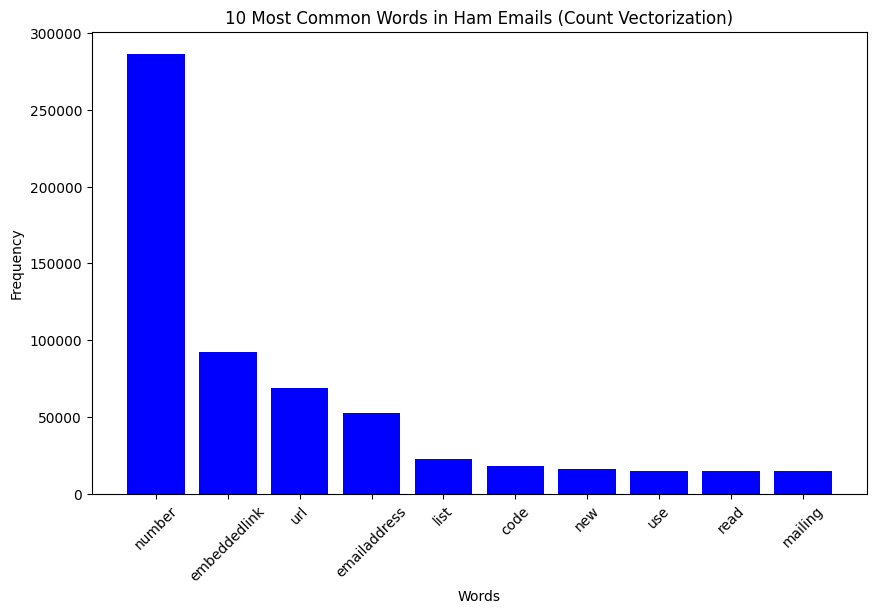

In [38]:
# Filter ham emails
ham_emails = combined_df[combined_df['label'] == 'ham']['processed_text']

# Count vectorizer to get word frequencies
X_counth = count_vectorizer.fit_transform(ham_emails)

# Get word counts
word_counts_ham = X_counth.sum(axis=0)
word_counts_ham = pd.DataFrame(word_counts_ham, columns=count_vectorizer.get_feature_names_out())
word_counts_ham = word_counts_ham.T  # Transpose to have words as rows
word_counts_ham.columns = ['count']
word_counts_ham = word_counts_ham.sort_values(by='count', ascending=False)

# Get the most common words
top_words_ham = word_counts_ham.head(10)

# Plotting the most common words from Count Vectorization
plt.figure(figsize=(10, 6))
plt.bar(top_words_ham.index, top_words_ham['count'], color='blue')
plt.title('10 Most Common Words in Ham Emails (Count Vectorization)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

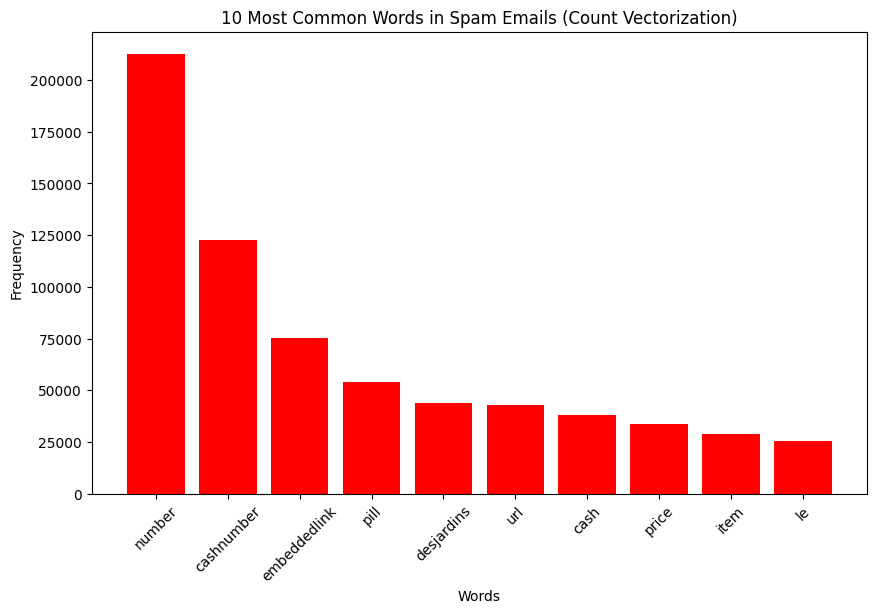

In [39]:
# Filter spam emails
spam_emails = combined_df[combined_df['label'] == 'spam']['processed_text']

# Count vectorizer to get word frequencies
X_count = count_vectorizer.fit_transform(spam_emails)

# Get word counts
word_counts_spam = X_count.sum(axis=0)
word_counts_spam = pd.DataFrame(word_counts_spam, columns=count_vectorizer.get_feature_names_out())
word_counts_spam = word_counts_spam.T  # Transpose to have words as rows
word_counts_spam.columns = ['count']
word_counts_spam = word_counts_spam.sort_values(by='count', ascending=False)

# Get the most common words
top_words_spam = word_counts_spam.head(10)

# Plotting the most common words from Count Vectorization
plt.figure(figsize=(10, 6))
plt.bar(top_words_spam.index, top_words_spam['count'], color='red')
plt.title('10 Most Common Words in Spam Emails (Count Vectorization)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Model Training

In [42]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(Xfinal, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

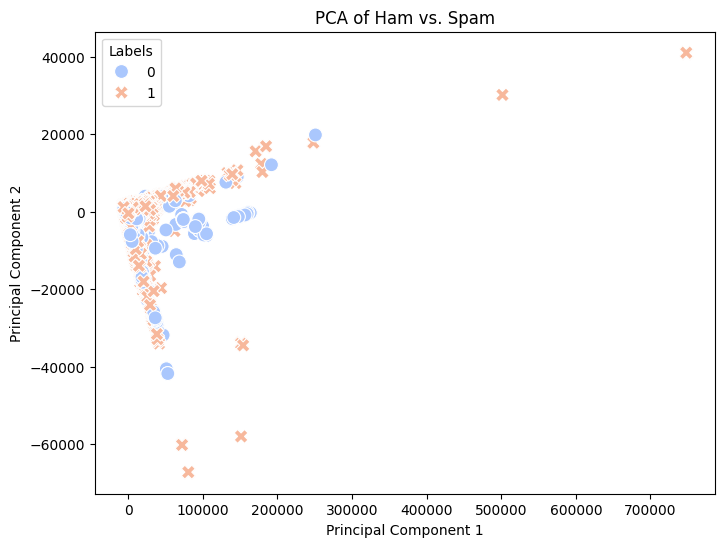

Explained variance ratio by each component: [0.96406352 0.03570167]


In [43]:
# Check if data is linear
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA on training data
X_train_pca = pca.fit_transform(X_train)

# Plot the data after PCA reduction
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, style=y_train, palette='coolwarm', s=100)
plt.title('PCA of Ham vs. Spam')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Labels')
plt.show()

# Print explained variance ratio to see how much variance is captured by each component
print("Explained variance ratio by each component:", pca.explained_variance_ratio_)

96.41% of the variation explained by the first principal component, shows that the data is mostly linear. This means that it can be represented by one main direction. It may be linearly separable.

In [44]:
# Encountered an issue where NB was throwing an error because of negative value
# Show how many negative values exist
print((X_train < 0).sum())

0


In [45]:
# Initialize classifiers with class balance to help with data being imbalanced
# svm is linear
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear'),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', C=1.0, random_state=42, class_weight='balanced', probability=True)
}

In [47]:
# Initialize results and confusion matrices list
results = []
confusion_matrices = []

# Initialize the predictions dictionary
predictions = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")

    # Apply scaling for SVC
    if name == "SVM":
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train if name == "SVM" else X_train)
        X_test_scaled = scaler.transform(X_test)

    if name == "SVM":
        clf.fit(X_train_scaled, y_train)
    else:
        clf.fit(X_train, y_train)

    # Progress tracking for the entire dataset (Ham + Spam)
    with tqdm(total=X_train.shape[0], desc=f"{name} - Training", unit="data") as pbar:
        for data_point in range(X_train.shape[0]):
            time.sleep(0.01)  # simulate processing time for each sample
            pbar.update(1)

    # Save the trained model
    joblib.dump(clf, f'{name.replace(" ", "_").lower()}_model.pkl')

    # Make predictions on the test and train set
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    predictions[name] = y_pred_test  # Store predictions in the dictionary

    # Calculate and store confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    cm_df = pd.DataFrame(cm, index=['Actual Ham', 'Actual Spam'], columns=['Predicted Ham', 'Predicted Spam'])
    confusion_matrices.append((name, cm_df))

    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Extract Precision, Recall, F1 Score for Ham and Spam from classification report
    report = classification_report(y_test, y_pred_test, target_names=['Ham', 'Spam'], output_dict=True)
    precision_ham = report['Ham']['precision']
    recall_ham = report['Ham']['recall']
    f1_ham = report['Ham']['f1-score']

    precision_spam = report['Spam']['precision']
    recall_spam = report['Spam']['recall']
    f1_spam = report['Spam']['f1-score']

    # Calculate AUC-ROC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_prob)

    # Store all metrics in the results list
    results.append({
        'Classifier': name,
        'Precision (Ham)': precision_ham,
        'Recall (Ham)': recall_ham,
        'F1 Score (Ham)': f1_ham,
        'Precision (Spam)': precision_spam,
        'Recall (Spam)': recall_spam,
        'F1 Score (Spam)': f1_spam,
        'AUC-ROC': auc_roc,
        'Accuracy on Test Set': accuracy_test,
        'Accuracy on Train Set': accuracy_train
    })

# Save results as DataFrame
results_df = pd.DataFrame(results)

# Prepare a summary DataFrame to display all confusion matrices
summary_cm_df = pd.concat([cm for name, cm in confusion_matrices], keys=[name for name, _ in confusion_matrices])


Training Naive Bayes...


Naive Bayes - Training: 100%|██████████| 54298/54298 [09:20<00:00, 96.95data/s]



Training Logistic Regression...


Logistic Regression - Training: 100%|██████████| 54298/54298 [09:19<00:00, 97.00data/s]



Training KNN...


KNN - Training: 100%|██████████| 54298/54298 [09:19<00:00, 97.04data/s]



Training Decision Tree...


Decision Tree - Training: 100%|██████████| 54298/54298 [09:19<00:00, 97.03data/s]



Training Random Forest...


Random Forest - Training: 100%|██████████| 54298/54298 [09:19<00:00, 96.98data/s]



Training SVM...


SVM - Training: 100%|██████████| 54298/54298 [09:19<00:00, 96.99data/s]


## Evaluate

In [48]:
# Display the results
print("Evaluation Results:")
results_df

Evaluation Results:


,Classifier,Precision (Ham),Recall (Ham),F1 Score (Ham),Precision (Spam),Recall (Spam),F1 Score (Spam),AUC-ROC,Accuracy on Test Set,Accuracy on Train Set
0,Naive Bayes,0.419484,0.972499,0.586139,0.955734,0.306129,0.463724,0.872027,0.532818,0.525784
1,Logistic Regression,0.990515,0.995019,0.992762,0.997426,0.995088,0.996256,0.998815,0.995064,0.994917
2,KNN,0.908003,0.904071,0.906033,0.950652,0.952774,0.951712,0.972156,0.936206,1.000000
3,Decision Tree,0.992860,0.993720,0.993290,0.996761,0.996316,0.996538,0.995018,0.995433,1.000000
4,Random Forest,0.998265,0.996752,0.997508,0.998327,0.999107,0.998717,0.999976,0.998306,1.000000
5,SVM,0.024691,0.000866,0.001674,0.656005,0.982360,0.786679,0.480577,0.648471,0.647593


In [49]:
# Sort the results DataFrame by 'Accuracy' in descending order
results_df_sorted = results_df.sort_values(by='Accuracy on Test Set', ascending=False)

print("Evaluation results with the best accuracy leading:")
results_df_sorted

Evaluation results with the best accuracy leading:


,Classifier,Precision (Ham),Recall (Ham),F1 Score (Ham),Precision (Spam),Recall (Spam),F1 Score (Spam),AUC-ROC,Accuracy on Test Set,Accuracy on Train Set
4,Random Forest,0.998265,0.996752,0.997508,0.998327,0.999107,0.998717,0.999976,0.998306,1.000000
3,Decision Tree,0.992860,0.993720,0.993290,0.996761,0.996316,0.996538,0.995018,0.995433,1.000000
1,Logistic Regression,0.990515,0.995019,0.992762,0.997426,0.995088,0.996256,0.998815,0.995064,0.994917
2,KNN,0.908003,0.904071,0.906033,0.950652,0.952774,0.951712,0.972156,0.936206,1.000000
5,SVM,0.024691,0.000866,0.001674,0.656005,0.982360,0.786679,0.480577,0.648471,0.647593
0,Naive Bayes,0.419484,0.972499,0.586139,0.955734,0.306129,0.463724,0.872027,0.532818,0.525784


In [50]:
# Print the confusion matrices
print("\nConfusion Matrices for All Classifiers:")
summary_cm_df


Confusion Matrices for All Classifiers:


Predicted Ham  Predicted Spam
Naive Bayes         Actual Ham            4491             127
                    Actual Spam           6215            2742
Logistic Regression Actual Ham            4595              23
                    Actual Spam             44            8913
KNN                 Actual Ham            4175             443
                    Actual Spam            423            8534
Decision Tree       Actual Ham            4589              29
                    Actual Spam             33            8924
Random Forest       Actual Ham            4603              15
                    Actual Spam              8            8949
SVM                 Actual Ham               4            4614
                    Actual Spam            158            8799

In [51]:
# classification report for each classifier as a table
for name, y_pred in tqdm(predictions.items(), desc="Generating reports", unit="classifier"):
    cr_dict = classification_report(y_test, y_pred, output_dict=True)

    # convert the dictionary to a dataframe
    cr_df = pd.DataFrame(cr_dict).transpose()

    # classification report
    print("\n")
    print(f"\nClassification Report for {name}, where Ham(0) and Spam(1):")
    print(cr_df.to_markdown())
    print("\n")

Generating reports:   0%|          | 0/6 [00:00<?, ?classifier/s]




Classification Report for Naive Bayes, where Ham(0) and Spam(1):


Generating reports:  17%|█▋        | 1/6 [00:00<00:00,  7.62classifier/s]

|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.419484 | 0.972499 |   0.586139 |  4618        |
| 1            |    0.955734 | 0.306129 |   0.463724 |  8957        |
| accuracy     |    0.532818 | 0.532818 |   0.532818 |     0.532818 |
| macro avg    |    0.687609 | 0.639314 |   0.524932 | 13575        |
| weighted avg |    0.77331  | 0.532818 |   0.505368 | 13575        |





Classification Report for Logistic Regression, where Ham(0) and Spam(1):
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.990515 | 0.995019 |   0.992762 |  4618        |
| 1            |    0.997426 | 0.995088 |   0.996256 |  8957        |
| accuracy     |    0.995064 | 0.995064 |   0.995064 |     0.995064 |
| macro avg    |    0.993971 | 0.995054 |   0.994509 | 13575        |
| weighted a

Generating reports:  50%|█████     | 3/6 [00:00<00:00, 11.97classifier/s]




Classification Report for Decision Tree, where Ham(0) and Spam(1):
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.99286  | 0.99372  |   0.99329  |  4618        |
| 1            |    0.996761 | 0.996316 |   0.996538 |  8957        |
| accuracy     |    0.995433 | 0.995433 |   0.995433 |     0.995433 |
| macro avg    |    0.994811 | 0.995018 |   0.994914 | 13575        |
| weighted avg |    0.995434 | 0.995433 |   0.995433 | 13575        |

Generating reports:  83%|████████▎ | 5/6 [00:00<00:00, 14.11classifier/s]







Classification Report for Random Forest, where Ham(0) and Spam(1):
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.998265 | 0.996752 |   0.997508 |  4618        |
| 1            |    0.998327 | 0.999107 |   0.998717 |  8957        |
| accuracy     |    0.998306 | 0.998306 |   0.998306 |     0.998306 |
| macro avg    |    0.998296 | 0.997929 |   0.998112 | 13575        |
| weighted avg |    0.998306 | 0.998306 |   0.998305 | 13575        |




Generating reports: 100%|██████████| 6/6 [00:00<00:00, 13.81classifier/s]




Classification Report for SVM, where Ham(0) and Spam(1):
|              |   precision |      recall |   f1-score |      support |
|:-------------|------------:|------------:|-----------:|-------------:|
| 0            |   0.0246914 | 0.000866176 | 0.00167364 |  4618        |
| 1            |   0.656005  | 0.98236     | 0.786679   |  8957        |
| accuracy     |   0.648471  | 0.648471    | 0.648471   |     0.648471 |
| macro avg    |   0.340348  | 0.491613    | 0.394176   | 13575        |
| weighted avg |   0.441242  | 0.648471    | 0.519632   | 13575        |




In [52]:
# Filter to show joblib model files (with .pkl extension)
model_files = [f for f in os.listdir('./') if f.endswith('.pkl')]
print(model_files)

['random_forest_model.pkl', 'logistic_regression_model.pkl', 'Xcombined.pkl', 'count_vectorizer.pkl', 'edf.pkl', 'combined_df.pkl', 'knn_model.pkl', 'tfidf_vectorizer.pkl', 'decision_tree_model.pkl', 'naive_bayes_model.pkl', 'svm_model.pkl']


## Cross Validation For Random Forest

In [53]:
from sklearn.model_selection import train_test_split, StratifiedKFold


# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Set up Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to hold scores
scores = []

# Perform Cross-Validation
for fold_index, (train_index, test_index) in enumerate(tqdm(skf.split(Xcombined, y), total=skf.get_n_splits(), desc='Cross-Validation Progress')):
    X_train, X_test = Xcombined[train_index], Xcombined[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_classifier.fit(X_train, y_train)  # Fit the model
    y_pred = rf_classifier.predict(X_test)  # Predict on the test set
    score = f1_score(y_test, y_pred, average='macro')  # Get the F1 score
    scores.append(score)

    tqdm.write(f"Fold {fold_index + 1}/{skf.get_n_splits()}: F1 Score = {score:.4f}")

# Convert scores for easier calculations
scores = np.array(scores)

# Print the results
print(" ")
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Score: {scores.mean():.2f} +/- {scores.std():.2f}")

Cross-Validation Progress:  20%|██        | 1/5 [02:39<10:38, 159.55s/it]

Fold 1/5: F1 Score = 0.9956


Cross-Validation Progress:  40%|████      | 2/5 [05:14<07:50, 156.79s/it]

Fold 2/5: F1 Score = 0.9958


Cross-Validation Progress:  60%|██████    | 3/5 [07:44<05:07, 153.76s/it]

Fold 3/5: F1 Score = 0.9960


Cross-Validation Progress:  80%|████████  | 4/5 [10:21<02:35, 155.10s/it]

Fold 4/5: F1 Score = 0.9966


Cross-Validation Progress: 100%|██████████| 5/5 [13:02<00:00, 156.47s/it]

Fold 5/5: F1 Score = 0.9964
 
Cross-Validation Scores: [0.99560103 0.99575267 0.99597442 0.99657284 0.99642489]
Mean Score: 1.00 +/- 0.00


## User Interaction

In [54]:
# Stripping HTML and replacing links
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    for a in soup.find_all('a', href=True):
        a.replace_with(f'embeddedlink {a.get_text()}')
    text = soup.get_text()
    return text


# List of keywords to remove lines starting with these patterns
keywords = [
    'From', 'To', 'Subject', 'Date', 'Received', 'Message-ID', 'Return-Path',
    'X-Mailer', 'List-', 'Old-Return-Path', 'X-Spam-Checker-Version','X-Virus-Scanned',
    'X-Spam-Level', 'X-Spam-Status', 'X-Original-To', 'User-Agent','X-MIMETrack','Sent',
    'MIME-Version', 'Content-Type', 'Content-Transfer-Encoding','Thread-Topic','charset','tests',
    'X-RC-Spam', 'X-RC-Virus', 'Resent-Message-ID', 'Resent-From','Reply-To','Content-class',
    'Delivered-To','X-BeenThere','Sender','New Revision','Author','Errors-To','X-Mailman-Version',
    'X-Mailing-List', 'X-Loop', 'List-ID', 'List-Post', 'List-Help','port','Thread-Index','In-Reply-To',
    'List-Subscribe', 'List-Unsubscribe', 'Precedence', 'Resent-Sender','Mailing-List','References',
    'Resent-Date', 'Status', 'Content-Length', 'Lines', 'Message-Id','by','for','id','Cc'
]

# Compile regex pattern with keywords and optional spacing
pattern = r'^\s*(?:' + '|'.join([f'{kw}(?:\\s*:)?' for kw in keywords]) + r'|' \
          r'DKIM_POLICY_SIGNSOME|X-|plot\.zoo).*'

# Function to remove headers line-by-line
def remove_header(text):

    # Remove any headers that match the pattern
    text = remove_html(text)
    text = re.sub(r'[\[\]<>()]', '', text)
    text_lines = text.splitlines()
    cleaned_lines = [line for line in text_lines if not re.match(pattern, line, re.IGNORECASE)]
    cleaned_text = "\n".join(cleaned_lines)

    cleaned_text = re.sub(
    r'\s*(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun),? +\w{3} +\d{1,2} +\d{2}:\d{2}:\d{2} +\d{4} ?(?:\([A-Z]+\))? *\n*|'
    r'(?<!\d)\d{1,2} +\w{3} +\d{4} +\d{2}:\d{2}:\d{2} +[-+]\d{4} ?(?:\([A-Z]+\))? *\n*|'
    r'(?<!\d)\d{1,2}\.\d{1,2}\.\d{4} +\d{2}:\d{2}:\d{2} *\n*',
    '',  cleaned_text, flags=re.IGNORECASE
)

    cleaned_text = re.sub(r'mailto:', '', cleaned_text)
    # Replace `?subject=subscribe` with `emailsubscribe`
    cleaned_text = re.sub(r'\S+@\S+\?subject=subscribe', 'emailsubscribe', cleaned_text, flags=re.IGNORECASE)

    # Replace `?subject=unsubscribe` with `emailunsubscribe`
    cleaned_text = re.sub(r'\S+@\S+\?subject=unsubscribe', 'emailunsubscribe', cleaned_text, flags=re.IGNORECASE)

    # Replace any IP address with 'ipaddr'
    cleaned_text = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', 'ipaddr', cleaned_text)

    return cleaned_text


     # Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_email(text):

    # Lower-casing
    text = text.lower()

    # Normalize whitespace to handle double spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove dates in various formats
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun),? +\w{3} +\d{1,2} +\d{2}:\d{2}:\d{2} +\d{4}\b|'
                  r'(?<!\d)\d{1,2} +\w{3} +\d{4} +\d{2}:\d{2}:\d{2} [-+]\d{4}\b', '', text)



   # Stripping HTML and replacing links
    soup = BeautifulSoup(text, 'html.parser')
    for a in soup.find_all('a', href=True):
        # Replace anchor tags with "embeddedlink" and the text of the anchor
        a.replace_with(f'embeddedlink {a.get_text()}')
    text = soup.get_text()

    # Normalizing URLs
    text = re.sub(r'http[s]?://\S+', 'url', text)

    # Normalizing Email Addresses
    text = re.sub(r'\S+@\S+', 'emailaddress', text)

   # Replace occurrences of currency followed by a number ($100) with "cash"
    text = re.sub(r'[$€¥£]\d+', 'cash', text)

    # Normalizing numbers
    text = re.sub(r'\b\d+\b', 'number', text)

    # Normalizing currency symbols
    text = re.sub(r'[$€¥£]', 'currency', text)

    # Replace non-ASCII characters (emojis) with 'emoji'
    text = re.sub(r'[^\x00-\x7F]+', 'emoji', text)

    # Removal of non-words and trimming whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

   # Make multiple "number" into a single "number"
    text = re.sub(r'(number\s*)+', 'number ', text)
    text = re.sub(r'number\s*number', 'number', text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Handle negations
    tokens = [re.sub(r'\b(not|no|never)\s+(\w+)', r'\2_\1', token) for token in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Word Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [56]:
import os
import joblib
import textwrap
import scipy.sparse as sp
import pandas as pd
from datetime import datetime

# Directories
colab_dir = '/content'
emails_dir = 'extracted_files/cmm541data/emails'

# Load trained model and vectorizers
model = joblib.load('random_forest_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Input email source
while True:
    email_source = input("Do you want to input an email as text (type 'text') or provide a file (type 'file')? ").strip().lower()
    if email_source in ['text', 'file']:
        break
    else:
        print("Invalid input. Please type 'text' or 'file'.")

if email_source == 'text':
    # User provides email as text
    user_input = input("Please copy and paste the email message you want to test: ")

    # Process the user input
    processed_mail1 = remove_header(user_input)
    processed_mail = preprocess_email(processed_mail1)

    new_mail = [processed_mail]

elif email_source == 'file':
    # User provides email as a file
    file_name = input("Please enter the name of the email file ('email.txt'): ").strip()
    file_path_colab = os.path.join(colab_dir, file_name)
    file_path_email_dir = os.path.join(emails_dir, file_name)
    file_path = file_path_colab if os.path.exists(file_path_colab) else file_path_email_dir

    try:
        with open(file_path, 'r', encoding='utf-8') as email_file:
            email_content = email_file.read()

        processed_content1 = remove_header(email_content)
        processed_content = preprocess_email(processed_content1)

        print("Processed Email Input (Truncated):", textwrap.fill(processed_content, width=70)[:1000])

        new_mail = [processed_content]

    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist in '{colab_dir}' or '{emails_dir}'.")
        new_mail = []
    except UnicodeDecodeError:
        print("Error: Unable to decode the file. Ensure it is a plain text file.")
        new_mail = []
    except Exception as e:
        print("An error occurred:", e)
        new_mail = []

if new_mail:
    try:
        # Transform the email using vectorizers
        new_count_features = count_vectorizer.transform(new_mail)
        new_tfidf_features = tfidf_vectorizer.transform(new_mail)

        # Combine vectorized features
        new_combined_features = sp.hstack((new_count_features, new_tfidf_features))

        # Extract metadata features
        metadata_features = pd.DataFrame([{
            'word_count_after': len(new_mail[0]),
            'is_reply': int(new_mail[0].startswith('Re:')),
            'is_forward': int(new_mail[0].startswith('Fwd:')),
            'is_business_hour': int(8 <= datetime.utcnow().hour <= 17)
        }])

        # Combine vectorized and metadata features
        new_data_features = sp.hstack((new_combined_features, sp.csr_matrix(metadata_features.values)))

        # Pad features to match the expected input size
        current_feature_count = new_data_features.shape[1]
        expected_feature_count = model.n_features_in_
        if current_feature_count < expected_feature_count:
            padding = sp.csr_matrix((new_data_features.shape[0], expected_feature_count - current_feature_count))
            new_data_features = sp.hstack((new_data_features, padding))
        elif current_feature_count > expected_feature_count:
            raise ValueError("Input features exceed the expected number of features.")

        # Make predictions
        prediction = model.predict(new_data_features)
        predicted_label = "Spam" if prediction[0] == 1 else "Legitimate"
        print("Classification Result:", predicted_label)
        print("Correct Label From Data Provided:", elabel.loc[elabel['email_file'] == f"../emails/{file_name}", 'label'].iloc[0])

    except ValueError as e:
        print("Error during classification:", e)


Do you want to input an email as text (type 'text') or provide a file (type 'file')? files
Invalid input. Please type 'text' or 'file'.
Do you want to input an email as text (type 'text') or provide a file (type 'file')? cmm541email.5
Invalid input. Please type 'text' or 'file'.
Do you want to input an email as text (type 'text') or provide a file (type 'file')? file
Please enter the name of the email file ('email.txt'): cmm541email.5
Processed Email Input (Truncated): typemultipartalternative boundarynextpart000001901c77a12c744e6d0
multipart message mime format nextpart000001901c77a12c744e6d0
boundarynextpart001001a01c77a12c744e6d0
nextpart001001a01c77a12c744e6d0 system home capability linked far know
within part respect affect technology society science ad agency cashin
g commerciality photograph paint electronic canvas still seems like
silence white black light didnt happen although far p erfect
especially precludes vast explanation understand people rely
avantgardes art world addit

## Save Files

In [57]:
# Define the name of the zip file
zipname = 'ml_jobs.zip'
exclude_file = 'cmm541data_1st diet.zip'  # File to exclude

# Specify the desired file extensions
ext = ('.pkl', '.csv', '.xlsx')

# finding all files to be zipped
files_to_zip = []
for file in os.listdir('.'):
    if file.endswith(ext) and file != exclude_file:
        files_to_zip.append(os.path.join('.', file))

# a zip file is created
with zipfile.ZipFile(zipname, 'w') as zipf:
    for file_path in tqdm(files_to_zip, desc='Zipping files', unit='file'):
        zipf.write(file_path, os.path.relpath(file_path, '.'), compress_type=zipfile.ZIP_DEFLATED)

print(f'\nAll files have been zipped into {zipname}')

# List the contents of the zip file
with zipfile.ZipFile(zipname, 'r') as zipf:
    print('Files zipped:')
    for file_info in zipf.infolist():
        print(file_info.filename)

Zipping files: 100%|██████████| 11/11 [01:45<00:00,  9.60s/file]


All files have been zipped into ml_jobs.zip
Files zipped:
random_forest_model.pkl
logistic_regression_model.pkl
Xcombined.pkl
count_vectorizer.pkl
edf.pkl
combined_df.pkl
knn_model.pkl
tfidf_vectorizer.pkl
decision_tree_model.pkl
naive_bayes_model.pkl
svm_model.pkl


**Reflections**

*   Data Preparation is Key: Most of the work lies in understanding and preparing the data.
*  Preprocessing: Effective data preprocessing is essential for better performance.
*  Address Data Imbalance: Solving label imbalance improves model results.
*   Modeling & Evaluation: A smaller portion of the work, but selecting the right model and evaluation metrics is crucial.
*  Evaluation Metrics: Focus on accuracy across different labels, not just total accuracy.